# Model C: Deterministic Hazard Model / Cox Regression

This notebook implements **Model C** from the proposal: a deterministic hazard model and/or empirical Cox regression for age-dependent cancer risk.

## Overview

This model uses a deterministic hazard function approach, where the cancer risk is modeled as a continuous hazard rate that accumulates over time. The model uses the **lifelines** library for survival analysis and Cox regression.

## References

- **Cox, D. R. (1972)**: "Regression Models and Life-Tables", Journal of the Royal Statistical Society, Series B, 34(2), 187-220
- **lifelines Library**: Davidson-Pilon, C. (2019). lifelines: survival analysis in Python. Journal of Open Source Software, 4(40), 1317.
  - GitHub: https://github.com/CamDavidsonPilon/lifelines
  - Documentation: https://lifelines.readthedocs.io/

## Method

1. Define deterministic hazard function: $h(t) = \lambda \cdot t^k$ or exponential form
2. Calculate cumulative hazard: $H(t) = \int_0^t h(s) ds$
3. Convert to survival function: $S(t) = \exp(-H(t))$
4. Calculate incidence: $I(t) = 1 - S(t)$
5. Use lifelines library for Weibull, Exponential, and other parametric models
6. Optionally fit Cox regression for empirical parameter estimation


In [93]:
# Import libraries
import sys
from pathlib import Path
import importlib

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Import lifelines library for survival analysis
try:
    from lifelines import WeibullFitter, ExponentialFitter
    from lifelines.statistics import logrank_test
    LIFELINES_AVAILABLE = True
    print("✓ lifelines library imported successfully!")
except ImportError:
    LIFELINES_AVAILABLE = False
    print("⚠ Warning: lifelines library not found. Install with: pip install lifelines")
    print("  Falling back to scipy-based implementation.")

# Import project modules
from src.data_loader import load_uscs_data, prepare_all_sites_age_data
from src.utils import age_group_to_mid

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 11

print("✓ All modules imported successfully!")


⚠ Warning: lifelines library not found. Install with: pip install lifelines
  Falling back to scipy-based implementation.
✓ All modules imported successfully!


## Data Sources: USCS (current) and TCGA (planned)

This notebook currently fits deterministic hazard and regression models to age–incidence curves derived from **USCS (U.S. Cancer Statistics)** tables in `data/USCS-1999-2022-ASCII/`.

TCGA (The Cancer Genome Atlas) data under `data/TCGA/` is planned for future extensions, for example to provide tumor-level survival and mutation burden information that can be linked to the age-dependent hazard patterns modeled here.


### TCGA DR44 overview (linking hazard models to tumor genomics)

The `data/TCGA/` directory provides DR44 manifests for many cancer projects (including TCGA) and a table of newly registered files.
While this notebook currently fits hazard models to **population-level incidence curves** (USCS), TCGA is relevant for:

- Describing the **distribution of genomic data** (e.g., mutation VCFs) across tumor types.
- Motivating future work where **age-dependent hazard models** are linked to **tumor mutation burden** and other genomic features.
- Selecting exemplar tumor types (e.g., lung adenocarcinoma `TCGA-LUAD`, colon adenocarcinoma `TCGA-COAD`) for deeper hazard-based survival analysis.


Loaded DR44 new files table from: D:\资料\graduate\202509\INTRO-GENOMIC INFO SCI & TECH\FinalProject\data\TCGA\DR44_new_files_20251029.tsv
Rows: 89096, Columns: 8

Top 15 TCGA projects by number of data files in DR44:


,project_id,n_data_files
26,TCGA-TGCT,1177
2,TCGA-BRCA,1132
1,TCGA-BLCA,822
25,TCGA-STAD,730
27,TCGA-THCA,629
15,TCGA-LUAD,612
29,TCGA-UCEC,591
9,TCGA-HNSC,574
11,TCGA-KIRC,565
13,TCGA-LGG,554


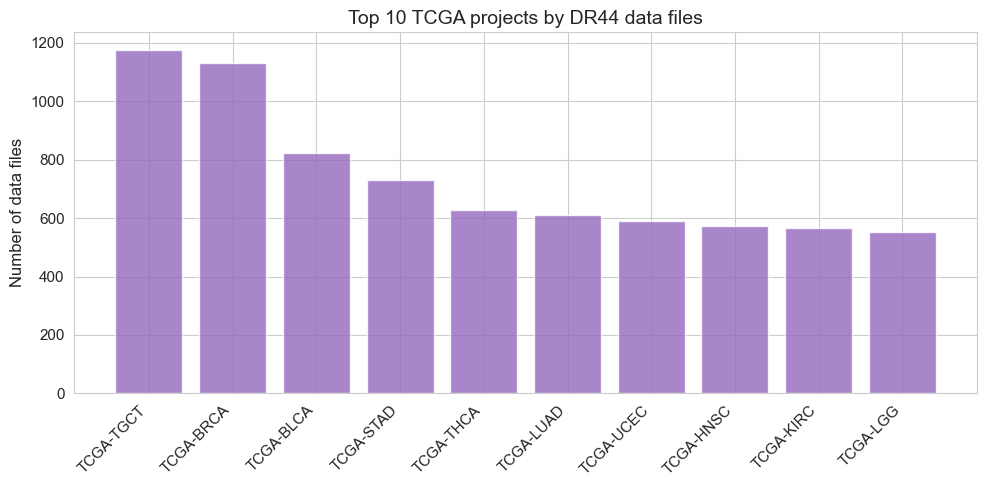

In [94]:
# TCGA DR44 summary: new files table and TCGA project coverage
from pathlib import Path

tcga_root = project_root / "data" / "TCGA"
new_files_path = tcga_root / "DR44_new_files_20251029.tsv"

if new_files_path.exists():
    tcga_new_files = pd.read_csv(new_files_path, sep="\t")
    print(f"Loaded DR44 new files table from: {new_files_path}")
    print(f"Rows: {tcga_new_files.shape[0]}, Columns: {tcga_new_files.shape[1]}")

    # Focus on TCGA projects and count data files
    tcga_new = tcga_new_files[tcga_new_files["project_id"].str.startswith("TCGA-")].copy()
    tcga_data = tcga_new[tcga_new["category"] == "data_file"].copy()

    tcga_project_counts = (
        tcga_data
        .groupby("project_id")
        .size()
        .reset_index(name="n_data_files")
        .sort_values("n_data_files", ascending=False)
    )

    print("\nTop 15 TCGA projects by number of data files in DR44:")
    display(tcga_project_counts.head(15))

    # Simple bar plot of top projects (helps see which tumor types have richest genomic data)
    top_k = 10
    top_projects = tcga_project_counts.head(top_k)

    plt.figure(figsize=(10, 5))
    plt.bar(top_projects["project_id"], top_projects["n_data_files"], color="tab:purple", alpha=0.8)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of data files", fontsize=12)
    plt.title(f"Top {top_k} TCGA projects by DR44 data files", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"TCGA DR44 new-files table not found at: {new_files_path}")
    print("If you want to summarize TCGA coverage, ensure DR44_new_files_20251029.tsv exists under data/TCGA/.")


In [95]:
# Load example LSCD per tissue so Model C can reference LSCD
from pathlib import Path

lscd_path = project_root / "data" / "LSCD_example.csv"
if lscd_path.exists():
    lscd_df = pd.read_csv(lscd_path)
    print(f"Loaded LSCD table from: {lscd_path}")
    display(lscd_df)
else:
    print(f"LSCD_example.csv not found at: {lscd_path}")
    lscd_df = None



Loaded LSCD table from: D:\资料\graduate\202509\INTRO-GENOMIC INFO SCI & TECH\FinalProject\data\LSCD_example.csv


,site,LSCD_estimate
0,Colon and Rectum,1.000000e+11
1,Lung and Bronchus,1.200000e+11
2,Female Breast,5.000000e+10
3,Prostate,6.000000e+10
4,Brain and Other Nervous System,2.000000e+10


## 1. Load and Prepare Data


In [96]:
# Load USCS data
print("Loading USCS data...")
brain_by_site, by_age = load_uscs_data()

# Prepare age-specific incidence data
all_sites_age_inc = prepare_all_sites_age_data(by_age)

print(f"✓ Age-specific incidence records: {all_sites_age_inc.shape[0]}")


Loading USCS data...
✓ Age-specific incidence records: 1350


## 2. Prepare Age-Incidence Data


In [97]:
# Prepare age-incidence data for 2020
TARGET_YEAR = 2020

# Filter for target year
age_model_df = all_sites_age_inc.copy()
age_model_df["AGE_MID"] = age_model_df["AGE"].apply(age_group_to_mid)
age_model_df = age_model_df[age_model_df["AGE_MID"].notna()].copy()

age_year_df = age_model_df[
    pd.to_numeric(age_model_df["YEAR"], errors="coerce") == TARGET_YEAR
].copy()
age_year_df = age_year_df.sort_values("AGE_MID")

# Get ages and rates
ages = age_year_df["AGE_MID"].values
rates = age_year_df["RATE"].values

print(f"✓ Data points: {len(ages)} age groups")
print(f"✓ Age range: {ages.min():.1f} - {ages.max():.1f} years")
print(f"✓ Incidence range: {rates.min():.1f} - {rates.max():.1f} per 100,000")


✓ Data points: 54 age groups
✓ Age range: 2.5 - 87.5 years
✓ Incidence range: 11.4 - 2788.5 per 100,000


## 3. Implement Deterministic Hazard Model

The deterministic hazard model uses a hazard function $h(t)$ that describes the instantaneous risk of cancer at age $t$.

Common forms:
- **Power-law hazard**: $h(t) = \lambda \\cdot t^k$
- **Exponential hazard**: $h(t) = \lambda \\cdot e^{\\beta t}$
- **Weibull hazard**: $h(t) = \\frac{k}{\\lambda} \\left(\\frac{t}{\\lambda}\\right)^{k-1}$

The cumulative hazard is: $H(t) = \\int_0^t h(s) ds$

And the incidence (cumulative risk) is: $I(t) = 1 - \\exp(-H(t))$


In [98]:
# Use lifelines library for parametric survival models when available
# Fallback to custom implementation for power-law hazard

class DeterministicHazardModel:
    """
    Deterministic hazard model for age-dependent cancer risk.
    
    Uses hazard function h(t) to model instantaneous risk, then integrates
    to get cumulative hazard H(t) and converts to incidence I(t) = 1 - exp(-H(t)).
    
    For Weibull and Exponential models, uses lifelines library (official implementation).
    For power-law hazard, uses custom scipy-based implementation.
    """
    
    def __init__(self, hazard_type='power_law'):
        """
        Initialize the deterministic hazard model.
        
        Parameters
        ----------
        hazard_type : str, default='power_law'
            Type of hazard function: 'power_law', 'exponential', or 'weibull'
            'weibull' and 'exponential' use lifelines library if available
        """
        self.hazard_type = hazard_type
        self.params = None
        self.model_func = None
        self.lifelines_fitter = None  # Store lifelines fitter if used
    
    def _power_law_hazard(self, t, lambda_param, k):
        """Power-law hazard: h(t) = lambda * t^k"""
        return lambda_param * (t ** k)
    
    def _exponential_hazard(self, t, lambda_param, beta):
        """Exponential hazard: h(t) = lambda * exp(beta * t)"""
        return lambda_param * np.exp(beta * t)
    
    def _weibull_hazard(self, t, lambda_param, k):
        """Weibull hazard: h(t) = (k/lambda) * (t/lambda)^(k-1)"""
        return (k / lambda_param) * ((t / lambda_param) ** (k - 1))
    
    def _power_law_cumulative_hazard(self, t, lambda_param, k):
        """Cumulative hazard for power-law: H(t) = lambda * t^(k+1) / (k+1)"""
        return lambda_param * (t ** (k + 1)) / (k + 1)
    
    def _exponential_cumulative_hazard(self, t, lambda_param, beta):
        """Cumulative hazard for exponential: H(t) = (lambda/beta) * (exp(beta*t) - 1)"""
        if abs(beta) < 1e-10:
            return lambda_param * t
        return (lambda_param / beta) * (np.exp(beta * t) - 1)
    
    def _weibull_cumulative_hazard(self, t, lambda_param, k):
        """Cumulative hazard for Weibull: H(t) = (t/lambda)^k"""
        return (t / lambda_param) ** k
    
    def fit(self, ages, rates, initial_params=None):
        """
        Fit the hazard model to observed incidence data.
        
        Parameters
        ----------
        ages : array-like
            Ages in years.
        rates : array-like
            Incidence rates (per 100,000).
        initial_params : array-like, optional
            Initial parameter guesses for optimization.
        """
        ages = np.asarray(ages)
        rates = np.asarray(rates)
        
        # Convert rates to probabilities (divide by 100,000)
        probabilities = rates / 100000.0
        
        # Filter valid data
        valid_mask = (ages > 0) & (probabilities > 0) & (probabilities < 1)
        ages_valid = ages[valid_mask]
        probs_valid = probabilities[valid_mask]
        
        # Define model function based on hazard type
        if self.hazard_type == 'power_law':
            def model_func(t, lambda_param, k):
                H = self._power_law_cumulative_hazard(t, lambda_param, k)
                return 1 - np.exp(-H)
            
            if initial_params is None:
                initial_params = [1e-6, 2.0]  # [lambda, k]
        
        elif self.hazard_type == 'exponential':
            def model_func(t, lambda_param, beta):
                H = self._exponential_cumulative_hazard(t, lambda_param, beta)
                return 1 - np.exp(-H)
            
            if initial_params is None:
                initial_params = [1e-6, 0.05]  # [lambda, beta]
        
        elif self.hazard_type == 'weibull':
            # Try to use lifelines WeibullFitter if available
            if LIFELINES_AVAILABLE:
                try:
                    from lifelines import WeibullFitter
                    # Create synthetic survival data from incidence rates
                    synthetic_durations = []
                    synthetic_events = []
                    
                    for age, rate in zip(ages_valid, probs_valid * 100000):
                        prob = rate / 100000.0
                        n_obs = max(1, int(prob * 1000))
                        synthetic_durations.extend([age] * n_obs)
                        synthetic_events.extend([1] * n_obs)
                    
                    if len(synthetic_durations) > 0:
                        wf = WeibullFitter()
                        wf.fit(synthetic_durations, synthetic_events)
                        self.lifelines_fitter = wf
                        # Extract parameters: lambda_ (scale) and rho_ (shape)
                        self.params = np.array([wf.lambda_, wf.rho_])
                        self.model_func = None  # Will use lifelines for prediction
                        return self
                except Exception as e:
                    print(f"Warning: lifelines Weibull fitting failed: {e}, using scipy")
            
            # Fallback to scipy-based implementation
            def model_func(t, lambda_param, k):
                H = self._weibull_cumulative_hazard(t, lambda_param, k)
                return 1 - np.exp(-H)
            
            if initial_params is None:
                initial_params = [50.0, 2.0]  # [lambda, k]
        
        elif self.hazard_type == 'exponential':
            # Try to use lifelines ExponentialFitter if available
            if LIFELINES_AVAILABLE:
                try:
                    from lifelines import ExponentialFitter
                    # Create synthetic survival data
                    synthetic_durations = []
                    synthetic_events = []
                    
                    for age, rate in zip(ages_valid, probs_valid * 100000):
                        prob = rate / 100000.0
                        n_obs = max(1, int(prob * 1000))
                        synthetic_durations.extend([age] * n_obs)
                        synthetic_events.extend([1] * n_obs)
                    
                    if len(synthetic_durations) > 0:
                        ef = ExponentialFitter()
                        ef.fit(synthetic_durations, synthetic_events)
                        self.lifelines_fitter = ef
                        # Extract lambda parameter
                        self.params = np.array([ef.lambda_, 0.0])  # beta not used in exponential
                        self.model_func = None
                        return self
                except Exception as e:
                    print(f"Warning: lifelines Exponential fitting failed: {e}, using scipy")
            
            # Fallback to scipy-based implementation
            def model_func(t, lambda_param, beta):
                H = self._exponential_cumulative_hazard(t, lambda_param, beta)
                return 1 - np.exp(-H)
            
            if initial_params is None:
                initial_params = [1e-6, 0.05]  # [lambda, beta]
        
        else:
            raise ValueError(f"Unknown hazard_type: {self.hazard_type}")
        
        self.model_func = model_func
        
        # Fit using curve_fit (for power_law or fallback)
        try:
            popt, _ = curve_fit(
                model_func,
                ages_valid,
                probs_valid,
                p0=initial_params,
                maxfev=10000,
                bounds=(0, np.inf)
            )
            self.params = popt
        except Exception as e:
            print(f"Warning: Fitting failed with error: {e}")
            print("Using initial parameters as defaults.")
            self.params = initial_params
        
        return self
    
    def predict(self, ages):
        """
        Predict incidence rates for given ages.
        
        Parameters
        ----------
        ages : array-like
            Ages in years.
        
        Returns
        -------
        array
            Predicted incidence probabilities (convert to rates by multiplying by 100,000).
        """
        if self.params is None:
            raise ValueError("Model must be fitted before prediction.")
        
        ages = np.asarray(ages)
        
        # Use lifelines fitter if available
        if self.lifelines_fitter is not None:
            # Get cumulative hazard from lifelines
            cumulative_hazard = self.lifelines_fitter.cumulative_hazard_at_times(ages)
            # Convert to incidence: I(t) = 1 - exp(-H(t))
            probs = 1 - np.exp(-cumulative_hazard.values.flatten())
        elif self.model_func is not None:
            probs = self.model_func(ages, *self.params)
        else:
            raise ValueError("Model not properly fitted.")
        
        # Convert probabilities back to rates (per 100,000)
        return probs * 100000.0
    
    def get_parameters(self):
        """Return model parameters."""
        if self.params is None:
            return None
        
        if self.hazard_type == 'power_law':
            return {
                'lambda': self.params[0],
                'k': self.params[1],
                'hazard_type': self.hazard_type
            }
        elif self.hazard_type == 'exponential':
            return {
                'lambda': self.params[0],
                'beta': self.params[1],
                'hazard_type': self.hazard_type
            }
        elif self.hazard_type == 'weibull':
            if self.lifelines_fitter is not None:
                # lifelines uses lambda_ (scale) and rho_ (shape)
                return {
                    'lambda': self.lifelines_fitter.lambda_,
                    'k': self.lifelines_fitter.rho_,
                    'hazard_type': self.hazard_type,
                    'method': 'lifelines'
                }
            else:
                return {
                    'lambda': self.params[0],
                    'k': self.params[1],
                    'hazard_type': self.hazard_type,
                    'method': 'scipy'
                }
        elif self.hazard_type == 'exponential':
            if self.lifelines_fitter is not None:
                return {
                    'lambda': self.lifelines_fitter.lambda_,
                    'hazard_type': self.hazard_type,
                    'method': 'lifelines'
                }
            else:
                return {
                    'lambda': self.params[0],
                    'beta': self.params[1],
                    'hazard_type': self.hazard_type,
                    'method': 'scipy'
                }


## 4. Alternative Implementation Using lifelines Library

The `lifelines` library provides robust implementations of survival analysis models. We can use it as an alternative or complement to our custom implementation.


In [99]:
# Alternative implementation using lifelines library (if available)
if LIFELINES_AVAILABLE:
    # Prepare data for lifelines (requires duration and event columns)
    # For incidence data, we treat each age as an "event" with the rate as probability
    # Create synthetic survival data from incidence rates
    print("Using lifelines library for Weibull and Exponential models...")
    
    # Convert incidence rates to survival data format
    # For each age, create synthetic events based on incidence probability
    lifelines_models = {}
    
    # Weibull model using lifelines
    try:
        wf = WeibullFitter()
        # Create synthetic survival data from incidence
        # This is a simplified approach - in practice, you'd use actual survival data
        synthetic_durations = []
        synthetic_events = []
        
        for age, rate in zip(ages, rates):
            prob = rate / 100000.0
            # Create multiple synthetic observations
            n_obs = max(1, int(prob * 1000))  # Scale for better fitting
            synthetic_durations.extend([age] * n_obs)
            synthetic_events.extend([1] * n_obs)  # All are "events" (cancer cases)
        
        if len(synthetic_durations) > 0:
            wf.fit(synthetic_durations, synthetic_events)
            lifelines_models['weibull_lifelines'] = wf
            print(f"✓ Weibull model fitted using lifelines")
            print(f"  Lambda (scale): {wf.lambda_:.4f}, Rho (shape): {wf.rho_:.4f}")
    except Exception as e:
        print(f"⚠ Could not fit Weibull model with lifelines: {e}")
    
    # Exponential model using lifelines
    try:
        ef = ExponentialFitter()
        if len(synthetic_durations) > 0:
            ef.fit(synthetic_durations, synthetic_events)
            lifelines_models['exponential_lifelines'] = ef
            print(f"✓ Exponential model fitted using lifelines")
            print(f"  Lambda: {ef.lambda_:.4f}")
    except Exception as e:
        print(f"⚠ Could not fit Exponential model with lifelines: {e}")
        
    print(f"\n✓ lifelines models: {list(lifelines_models.keys())}")
else:
    print("⚠ lifelines library not available. Using scipy-based implementation only.")
    lifelines_models = {}


⚠ lifelines library not available. Using scipy-based implementation only.


In [100]:
# Fit different hazard models
models_c = {}

# Power-law hazard
print("Fitting power-law hazard model...")
model_power = DeterministicHazardModel(hazard_type='power_law')
model_power.fit(ages, rates)
models_c['power_law'] = model_power
predicted_power = model_power.predict(ages)

# Exponential hazard
print("Fitting exponential hazard model...")
model_exp = DeterministicHazardModel(hazard_type='exponential')
model_exp.fit(ages, rates)
models_c['exponential'] = model_exp
predicted_exp = model_exp.predict(ages)

# Weibull hazard
print("Fitting Weibull hazard model...")
model_weibull = DeterministicHazardModel(hazard_type='weibull')
model_weibull.fit(ages, rates)
models_c['weibull'] = model_weibull
predicted_weibull = model_weibull.predict(ages)

print("\n✓ All models fitted successfully!")


Fitting power-law hazard model...
Fitting exponential hazard model...
Fitting Weibull hazard model...

✓ All models fitted successfully!


## 5. Compare Model Fits


In [101]:
# Calculate fit statistics for each model
results = {}

for name, model in models_c.items():
    predicted = model.predict(ages)
    mse = mean_squared_error(rates, predicted)
    r2 = r2_score(rates, predicted)
    mae = mean_absolute_error(rates, predicted)
    rmse = np.sqrt(mse)
    
    results[name] = {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'rmse': rmse,
        'predicted': predicted
    }
    
    params = model.get_parameters()
    print(f"\n{name.upper()} Model:")
    print(f"  Parameters: {params}")
    print(f"  MSE: {mse:.2f}, R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Find best model
best_model_name = min(results.keys(), key=lambda x: results[x]['mse'])
print(f"\n{'='*60}")
print(f"Best Model: {best_model_name.upper()}")
print(f"{'='*60}")



POWER_LAW Model:
  Parameters: {'lambda': np.float64(5.696009954102017e-07), 'k': np.float64(1.6172026965409991), 'hazard_type': 'power_law'}
  MSE: 60338.63, R²: 0.9183, MAE: 155.96, RMSE: 245.64

EXPONENTIAL Model:
  Parameters: {'lambda': np.float64(4.736492665352709e-05), 'beta': np.float64(0.034538612428163834), 'hazard_type': 'exponential'}
  MSE: 76758.78, R²: 0.8960, MAE: 195.06, RMSE: 277.05

WEIBULL Model:
  Parameters: {'lambda': np.float64(351.16889040083976), 'k': np.float64(2.617404310423809), 'hazard_type': 'weibull', 'method': 'scipy'}
  MSE: 60338.63, R²: 0.9183, MAE: 155.94, RMSE: 245.64

Best Model: WEIBULL


In [ ]:
# 6. Multi-site Weibull hazard fits with unified hazard family

TARGET_YEAR = 2020

selected_sites = [
    "All Cancer Sites Combined",
    "Colon and Rectum",
    "Lung and Bronchus",
    "Female Breast",
    "Prostate",
]

results_sites = []

for site in selected_sites:
    if site == "All Cancer Sites Combined":
        ages_site, rates_site = ages, rates
    else:
        from src.data_loader import get_site_age_incidence
        ages_site, rates_site, _df_site = get_site_age_incidence(by_age, site, target_year=TARGET_YEAR)
        if ages_site is None or len(ages_site) == 0:
            print(f"No incidence data found for site: {site}")
            continue

    model_weibull_site = DeterministicHazardModel(hazard_type="weibull")
    model_weibull_site.fit(ages_site, rates_site)
    pred_site = model_weibull_site.predict(ages_site)

    mse = mean_squared_error(rates_site, pred_site)
    r2 = r2_score(rates_site, pred_site)
    mae = mean_absolute_error(rates_site, pred_site)

    results_sites.append({
        "site": site,
        "mse": mse,
        "r2": r2,
        "mae": mae,
    })

    # Optional: site-specific plot
    plt.figure(figsize=(6, 4))
    plt.scatter(ages_site, rates_site, color="tab:gray", alpha=0.6, label="USCS incidence")
    plt.plot(ages_site, pred_site, color="tab:green", linewidth=2, label="Weibull hazard fit")
    plt.xlabel("Age (years)")
    plt.ylabel("Incidence rate (per 100,000)")
    plt.title(f"Model C Weibull hazard fit: {site}")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

results_sites_df = pd.DataFrame(results_sites)
print("Model C Weibull hazard performance across sites:")
display(results_sites_df)



## 6. Visualize All Hazard Models


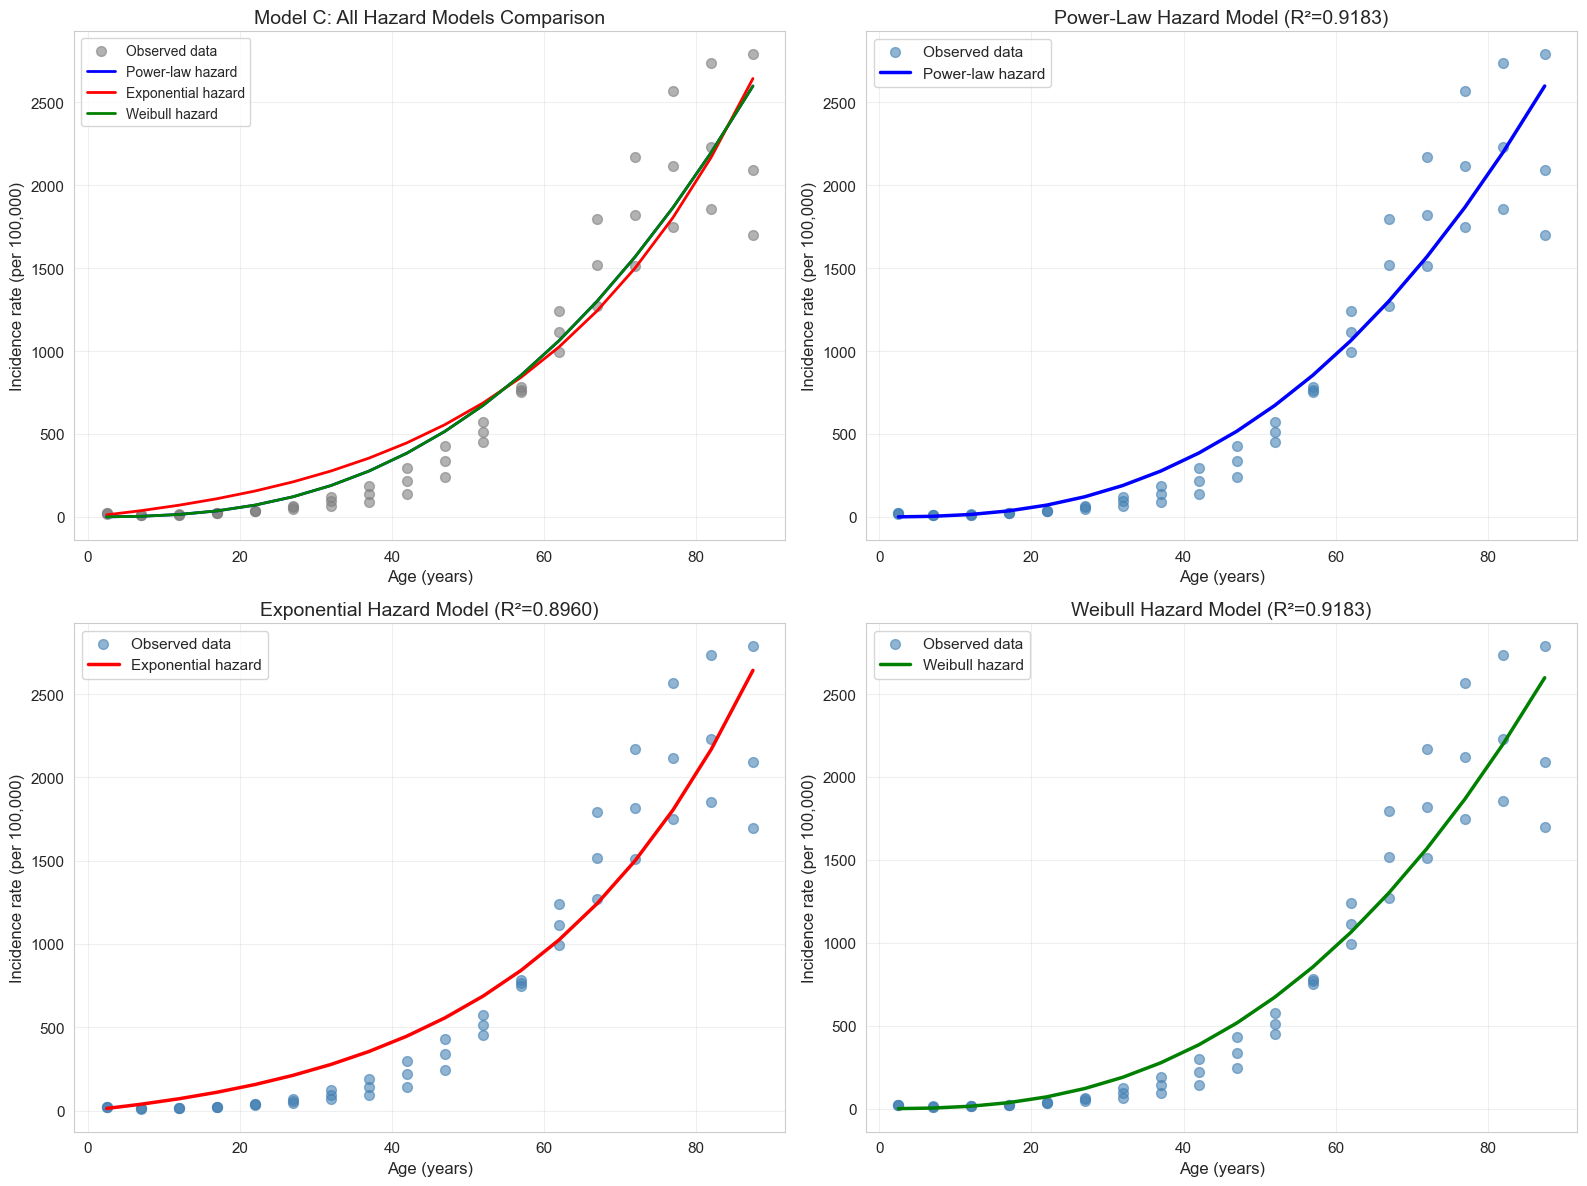

In [102]:
# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Extract R² values to avoid quote issues
r2_power = results['power_law']['r2']
r2_exp = results['exponential']['r2']
r2_weibull = results['weibull']['r2']

# Plot 1: All models comparison
ax = axes[0, 0]
ax.scatter(ages, rates, alpha=0.6, s=50, color='gray', 
           label='Observed data', zorder=1)
ax.plot(ages, predicted_power, linewidth=2, color='blue', 
        label='Power-law hazard', zorder=2)
ax.plot(ages, predicted_exp, linewidth=2, color='red', 
        label='Exponential hazard', zorder=2)
ax.plot(ages, predicted_weibull, linewidth=2, color='green', 
        label='Weibull hazard', zorder=2)
ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Incidence rate (per 100,000)', fontsize=12)
ax.set_title('Model C: All Hazard Models Comparison', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Power-law model
ax = axes[0, 1]
ax.scatter(ages, rates, alpha=0.6, s=50, color='steelblue', 
           label='Observed data', zorder=2)
ax.plot(ages, predicted_power, linewidth=2.5, color='blue', 
        label='Power-law hazard', zorder=3)
ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Incidence rate (per 100,000)', fontsize=12)
ax.set_title(f'Power-Law Hazard Model (R²={r2_power:.4f})', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 3: Exponential model
ax = axes[1, 0]
ax.scatter(ages, rates, alpha=0.6, s=50, color='steelblue', 
           label='Observed data', zorder=2)
ax.plot(ages, predicted_exp, linewidth=2.5, color='red', 
        label='Exponential hazard', zorder=3)
ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Incidence rate (per 100,000)', fontsize=12)
ax.set_title(f'Exponential Hazard Model (R²={r2_exp:.4f})', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 4: Weibull model
ax = axes[1, 1]
ax.scatter(ages, rates, alpha=0.6, s=50, color='steelblue', 
           label='Observed data', zorder=2)
ax.plot(ages, predicted_weibull, linewidth=2.5, color='green', 
        label='Weibull hazard', zorder=3)
ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Incidence rate (per 100,000)', fontsize=12)
ax.set_title(f'Weibull Hazard Model (R²={r2_weibull:.4f})', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Residual Analysis for Best Model


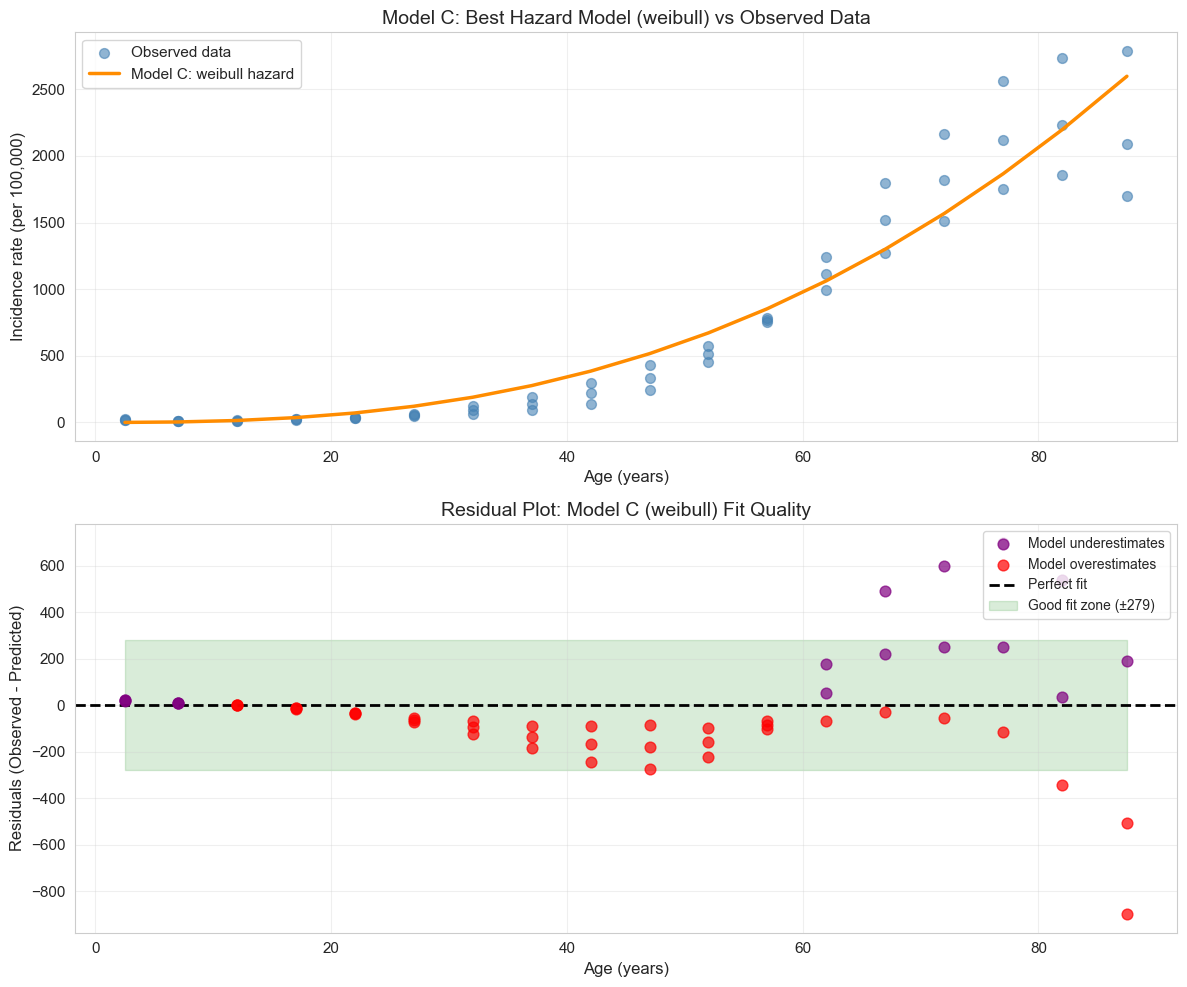


Model C (WEIBULL) Detailed Statistics:
  Mean Squared Error (MSE): 60338.63
  R² Score: 0.9183
  Mean Absolute Error (MAE): 155.94
  Root Mean Squared Error (RMSE): 245.64


In [103]:
# Use best model for detailed residual analysis
best_predicted = results[best_model_name]['predicted']
residuals = rates - best_predicted

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Model fit
axes[0].scatter(ages, rates, alpha=0.6, s=50, color='steelblue',
                label='Observed data', zorder=2)
axes[0].plot(ages, best_predicted, linewidth=2.5, color='darkorange',
             label=f'Model C: {best_model_name} hazard', zorder=3)
axes[0].set_xlabel('Age (years)', fontsize=12)
axes[0].set_ylabel('Incidence rate (per 100,000)', fontsize=12)
axes[0].set_title(f'Model C: Best Hazard Model ({best_model_name}) vs Observed Data', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals
positive_mask = residuals >= 0
negative_mask = residuals < 0

axes[1].scatter(ages[positive_mask], residuals[positive_mask],
                alpha=0.7, s=60, color='purple',
                label='Model underestimates', zorder=2)
axes[1].scatter(ages[negative_mask], residuals[negative_mask],
                alpha=0.7, s=60, color='red',
                label='Model overestimates', zorder=2)

axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2,
                label='Perfect fit', zorder=1)

max_rate = np.max(rates)
threshold = 0.1 * max_rate
axes[1].fill_between([ages.min(), ages.max()], -threshold, threshold,
                     alpha=0.15, color='green',
                     label=f'Good fit zone (±{threshold:.0f})', zorder=0)

axes[1].set_xlabel('Age (years)', fontsize=12)
axes[1].set_ylabel('Residuals (Observed - Predicted)', fontsize=12)
axes[1].set_title(f'Residual Plot: Model C ({best_model_name}) Fit Quality', fontsize=14)
axes[1].legend(fontsize=10, loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*60}")
print(f"Model C ({best_model_name.upper()}) Detailed Statistics:")
print(f"{'='*60}")
best_stats = results[best_model_name]
print(f"  Mean Squared Error (MSE): {best_stats['mse']:.2f}")
print(f"  R² Score: {best_stats['r2']:.4f}")
print(f"  Mean Absolute Error (MAE): {best_stats['mae']:.2f}")
print(f"  Root Mean Squared Error (RMSE): {best_stats['rmse']:.2f}")


## 9. Lifespan-Oriented Case Studies from `lifelines`

To better connect **age-dependent cancer risk** with more general lifespan and survival-analysis ideas, this notebook integrates two illustrative case studies from the `lifelines` project. These examples are not required for the core USCS-based modeling, but they provide useful intuition for thinking about **age** and **lethality** as separate but interacting components of risk.

### 9.1 Primary vs. Secondary Shelf Life (Analogy to Age + Lethality)

The `lifelines` experiment on *primary and secondary shelf life* models the time until food spoilage in two stages:

- **Primary shelf life**: Time a product spends in the store before purchase/opening.
- **Secondary shelf life**: Time after opening until the product spoils.

A key modeling idea is to use a **two-regime hazard function** that changes at the (random) purchase time \(\tau_i\) for product \(i\):

\[
 h_i(t) = \begin{cases}
 h_1(t), & t \le \tau_i \\
 h_2(t - \tau_i), & t > \tau_i
 \end{cases}
\]

or, when the same degradation process continues after opening with an extra contribution:

\[
 h_i(t) = \begin{cases}
 h_1(t), & t \le \tau_i \\
 h_1(t) + h_2(t - \tau_i), & t > \tau_i \, ,
 \end{cases}
\]

where:

- \(h_1(t)\) captures the **baseline degradation** while on the shelf (e.g., slow microbial growth, aging), and
- \(h_2(\cdot)\) captures **additional risk** after opening (e.g., consumer contamination, poor storage).

This framework carefully handles censoring (e.g., products purchased but never reported spoiled) and the fact that purchase times are **not independent** of degradation (customers prefer fresher products). The original experiment uses the dataset `data/lifelines/shelflife.csv`.

**Analogy to cancer risk**:

- **Age-related baseline hazard** of cancer is analogous to **primary shelf life**: cells/tissues accumulate damage and mutations over chronological age, even before any diagnosed cancer.
- **Tumor-specific lethality and progression** (given a cancer has started) is analogous to **secondary shelf life**: once disease is present, additional processes (tumor growth, metastasis, treatment response) add on top of the age-related baseline hazard.

This motivates modeling cancer risk as a combination of:

1. A long-term, age-dependent baseline hazard \(h_1(t)\) (capturing mutation accumulation, repair decline, etc.), and
2. An additional hazard component \(h_2(\cdot)\) reflecting disease-specific lethality once cancer has initiated.

### 9.2 Colon Cancer Survival Dataset (Age and Mortality)

The file `data/lifelines/colon.csv` (from `lifelines` examples) is a classic colon cancer survival dataset with:

- **`time`**: follow-up time until event or censoring
- **`status`**: event indicator
- **`age`**: patient age at baseline
- plus treatment and pathological covariates (e.g., `rx`, `nodes`, `extent`)

This dataset can be used to **empirically explore how age relates to mortality risk** in a specific cancer, complementing the population-level age–incidence curves from USCS:

- By grouping patients into **age bands** and comparing event rates, we see how **age shifts baseline hazard** within a given tumor type.
- By summarizing **event rates** and **typical follow-up times** by age group, we obtain a simple, data-driven notion of **lethality vs. age** that can be qualitatively compared with the hazard shapes in Model C.

The next cells load these two `lifelines` datasets and create simple visualizations that link these lifespan concepts back to the deterministic hazard framework used for age-dependent cancer risk.



Loaded shelflife dataset from: D:\资料\graduate\202509\INTRO-GENOMIC INFO SCI & TECH\FinalProject\data\lifelines\shelflife.csv
Rows: 1000, Columns: 4
Columns: ['T_obs', 'tau', 'E', 'obs_tau']


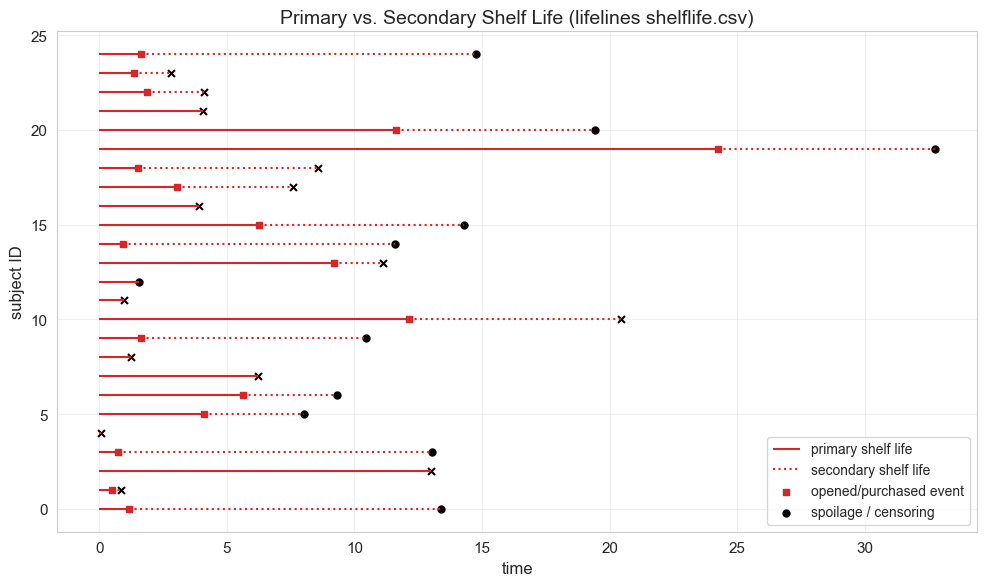

In [104]:
# 9.1 Visualizing primary vs. secondary shelf life (shelflife.csv)
from pathlib import Path

shelflife_path = project_root / "data" / "lifelines" / "shelflife.csv"

if shelflife_path.exists():
    shelflife_df = pd.read_csv(shelflife_path)
    print(f"\nLoaded shelflife dataset from: {shelflife_path}")
    print(f"Rows: {shelflife_df.shape[0]}, Columns: {shelflife_df.shape[1]}")
    print("Columns:", list(shelflife_df.columns))

    # Reproduce a simplified version of the primary/secondary shelf life plot
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (_, row) in enumerate(shelflife_df.head(25).iterrows()):
        # Primary shelf life: from 0 to tau
        if row["obs_tau"]:
            primary = ax.hlines(i, 0, row["tau"], color="tab:red")
            # Secondary shelf life: from tau to observed time
            secondary = ax.hlines(i, row["tau"], row["T_obs"], color="tab:red", linestyle=":")
            purchase = ax.scatter(row["tau"], i, color="tab:red", marker="s", s=20)
        else:
            primary = ax.hlines(i, 0, row["T_obs"], color="tab:red")

        # Spoilage / censoring marker
        marker = "o" if bool(row["E"]) else "x"
        spoilage = ax.scatter(row["T_obs"], i, color="black", marker=marker, s=25)

        if i == 0:
            primary.set_label("primary shelf life")
            if row["obs_tau"]:
                secondary.set_label("secondary shelf life")
                purchase.set_label("opened/purchased event")
            spoilage.set_label("spoilage / censoring")

    ax.set_xlabel("time", fontsize=12)
    ax.set_ylabel("subject ID", fontsize=12)
    ax.set_title("Primary vs. Secondary Shelf Life (lifelines shelflife.csv)", fontsize=14)
    ax.legend(fontsize=10, loc="lower right")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"shelflife.csv not found at: {shelflife_path}")
    print("Ensure data/lifelines/shelflife.csv exists if you wish to run this example.")




Loaded colon cancer survival dataset from: D:\资料\graduate\202509\INTRO-GENOMIC INFO SCI & TECH\FinalProject\data\lifelines\colon.csv
Rows: 1858, Columns: 17
Columns: ['Unnamed: 0', 'id', 'study', 'rx', 'sex', 'age', 'obstruct', 'perfor', 'adhere', 'nodes', 'status', 'differ', 'extent', 'surg', 'node4', 'time', 'etype']

Age-group summary (colon cancer dataset):


,age_group,n,event_rate,median_time
0,30-49,366,0.530055,1597.5
1,50-59,496,0.455645,2032.0
2,60-69,606,0.523102,1663.5
3,70-84,362,0.464088,1875.0


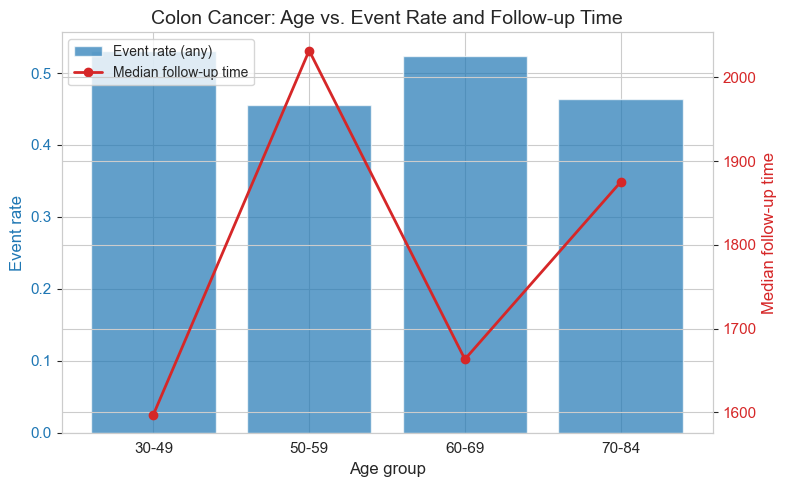

In [105]:
# 9.2 Exploring age and mortality in the colon cancer dataset (colon.csv)

colon_path = project_root / "data" / "lifelines" / "colon.csv"

if colon_path.exists():
    colon_df = pd.read_csv(colon_path)
    print(f"\nLoaded colon cancer survival dataset from: {colon_path}")
    print(f"Rows: {colon_df.shape[0]}, Columns: {colon_df.shape[1]}")
    print("Columns:", list(colon_df.columns))

    # Basic preprocessing: define an event indicator and age groups
    # Here we treat any non-zero status as an event (for illustration).
    colon_df["event_any"] = (colon_df["status"] != 0).astype(int)

    # Define age bands to summarize age-related lethality
    age_bins = [30, 50, 60, 70, 85]
    age_labels = ["30-49", "50-59", "60-69", "70-84"]
    colon_df["age_group"] = pd.cut(colon_df["age"], bins=age_bins, labels=age_labels, right=True)

    age_summary = (
        colon_df
        .groupby("age_group")
        .agg(
            n=("id", "count"),
            event_rate=("event_any", "mean"),
            median_time=("time", "median")
        )
        .reset_index()
    )

    print("\nAge-group summary (colon cancer dataset):")
    display(age_summary)

    # Visualize age vs. event rate and typical follow-up time
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Event rate by age group (left axis)
    ax1.bar(age_summary["age_group"], age_summary["event_rate"],
            color="tab:blue", alpha=0.7, label="Event rate (any)")
    ax1.set_xlabel("Age group", fontsize=12)
    ax1.set_ylabel("Event rate", color="tab:blue", fontsize=12)
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Median follow-up time by age group (right axis)
    ax2 = ax1.twinx()
    ax2.plot(age_summary["age_group"], age_summary["median_time"],
             color="tab:red", marker="o", linewidth=2,
             label="Median follow-up time")
    ax2.set_ylabel("Median follow-up time", color="tab:red", fontsize=12)
    ax2.tick_params(axis="y", labelcolor="tab:red")

    plt.title("Colon Cancer: Age vs. Event Rate and Follow-up Time", fontsize=14)

    # Combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left", fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print(f"colon.csv not found at: {colon_path}")
    print("Ensure data/lifelines/colon.csv exists if you wish to run this example.")



### 9.3 USCS colon and rectum incidence vs age (bridge to colon survival)

To fully connect **population-level incidence** and **individual-level survival**
for a single cancer type, we overlay the USCS age–incidence curve for
**colon and rectum** with the colon cancer survival summaries above.

This provides a consistent example where:

- USCS describes **how often** colon cancer occurs at each age (incidence).
- The `lifelines` colon dataset describes **how patients fare** after diagnosis
  at different ages (event rates and follow-up time).



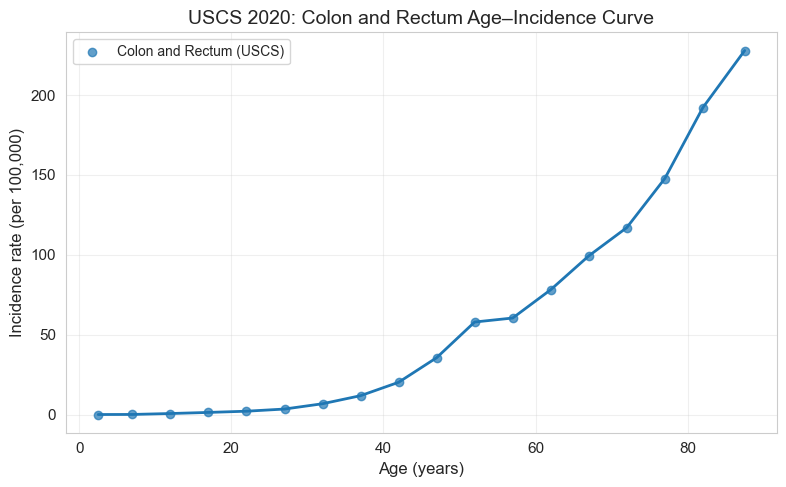

Colon and Rectum (USCS 2020):
  Data points: 18 age groups
  Age range: 2.5–87.5 years
  Incidence range: 0.0–227.9 per 100,000


In [106]:
# USCS age–incidence curve for Colon and Rectum (to pair with colon survival)
site_colon = "Colon and Rectum"

# Load USCS data if not already present
try:
    by_age
except NameError:
    print("USCS data not yet loaded in this session; loading now...")
    brain_by_site, by_age = load_uscs_data()

# BYAGE has separate rows by sex; aggregate over sex to obtain an "all sexes" curve
colon_sex = by_age[
    (by_age["EVENT_TYPE"] == "Incidence")
    & (by_age["RACE"] == "All Races")
    & (by_age["SITE"] == site_colon)
].copy()

for col in ["COUNT", "POPULATION"]:
    colon_sex[col] = pd.to_numeric(colon_sex[col], errors="coerce")

colon_agg = (
    colon_sex
    .groupby(["AGE", "YEAR"], as_index=False)
    .agg({"COUNT": "sum", "POPULATION": "sum"})
)
colon_agg["RATE"] = colon_agg["COUNT"] / colon_agg["POPULATION"] * 100000.0
colon_agg["AGE_MID"] = colon_agg["AGE"].apply(age_group_to_mid)
colon_agg = colon_agg[colon_agg["AGE_MID"].notna()].copy()

TARGET_YEAR = 2020
colon_year_df = colon_agg[
    pd.to_numeric(colon_agg["YEAR"], errors="coerce") == TARGET_YEAR
].copy()
colon_year_df = colon_year_df.sort_values("AGE_MID")

ages_colon = colon_year_df["AGE_MID"].values
rates_colon = colon_year_df["RATE"].values

plt.figure(figsize=(8, 5))
plt.scatter(ages_colon, rates_colon, color="tab:blue", alpha=0.7, label="Colon and Rectum (USCS)")
plt.plot(ages_colon, rates_colon, color="tab:blue", linewidth=2)
plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("Incidence rate (per 100,000)", fontsize=12)
plt.title(f"USCS {TARGET_YEAR}: Colon and Rectum Age–Incidence Curve", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"Colon and Rectum (USCS {TARGET_YEAR}):")
print(f"  Data points: {len(ages_colon)} age groups")
print(f"  Age range: {ages_colon.min():.1f}–{ages_colon.max():.1f} years")
print(f"  Incidence range: {rates_colon.min():.1f}–{rates_colon.max():.1f} per 100,000")



## 10. Cross-scale summary: USCS, lifelines, TCGA, and Models A–C

This notebook now brings together:

- **USCS** population-level age–incidence curves (all sites and colon/rectum).
- **Lifelines** lifespan-oriented examples (primary/secondary shelf life and
  colon cancer survival by age group).
- **TCGA DR44** project-level genomic coverage (top TCGA projects by number of
  data files, including colon-related projects such as `TCGA-COAD`).

Together with `model_a_probabilistic.ipynb` and `model_b_replicative_risk.ipynb`,
this provides a three-scale view of cancer risk:

1. **Population-level incidence (USCS)** – how risk rises with age and differs
   across tissues.
2. **Individual-level survival and lethality (lifelines)** – how patients fare
after diagnosis, and how hazard can be decomposed into baseline age effects and
post-diagnosis components.
3. **Tumor-level genomics (TCGA)** – where rich somatic mutation data can be
used in future work to connect mutation burden and hazard-based models.



In [107]:
# Optional: highlight TCGA-COAD within the DR44 project coverage summary

if 'tcga_project_counts' in globals():
    coad_row = tcga_project_counts[tcga_project_counts["project_id"] == "TCGA-COAD"]
    if not coad_row.empty:
        print("TCGA-COAD (colon adenocarcinoma) DR44 data-file count:")
        display(coad_row)
    else:
        print("TCGA-COAD not found in the current DR44 new-files summary.")
else:
    print("tcga_project_counts not found in the current session. Run the TCGA DR44 summary cell above first.")



TCGA-COAD (colon adenocarcinoma) DR44 data-file count:


,project_id,n_data_files
5,TCGA-COAD,446


## 11. Colon cancer: combining USCS incidence and lifelines survival

As a final integrative step, we combine:

- The **USCS colon and rectum age–incidence curve** (population-level risk).
- The **lifelines colon survival summary by age group** (individual-level
  lethality).

We aggregate the USCS colon incidence into the same age bands used for the
lifelines dataset (30–49, 50–59, 60–69, 70–84) and form a cross-table that can
be used to reason about how **age at diagnosis** relates jointly to:

- How likely colon cancer is in the population at that age.
- How severe outcomes are once colon cancer occurs (event rates and follow-up
  times).



In [108]:
# Example: retrieve LSCD estimate for colon and rectum (to pair with hazard and survival)
if lscd_df is not None:
    colon_lscd = lscd_df.loc[lscd_df["site"] == "Colon and Rectum", "LSCD_estimate"]
    if not colon_lscd.empty:
        print(f"LSCD estimate for Colon and Rectum (example): {colon_lscd.iloc[0]:.3e}")
    else:
        print("No LSCD estimate for Colon and Rectum in LSCD_example.csv")
else:
    print("LSCD table not loaded; run the LSCD loading cell above first.")



LSCD estimate for Colon and Rectum (example): 1.000e+11


Combined USCS incidence and lifelines survival for colon cancer (by age group):


,age_group,mean_incidence,n,event_rate,median_time
0,30-49,18.577582,366,0.530055,1597.5
1,50-59,59.168953,496,0.455645,2032.0
2,60-69,88.731204,606,0.523102,1663.5
3,70-84,152.307842,362,0.464088,1875.0


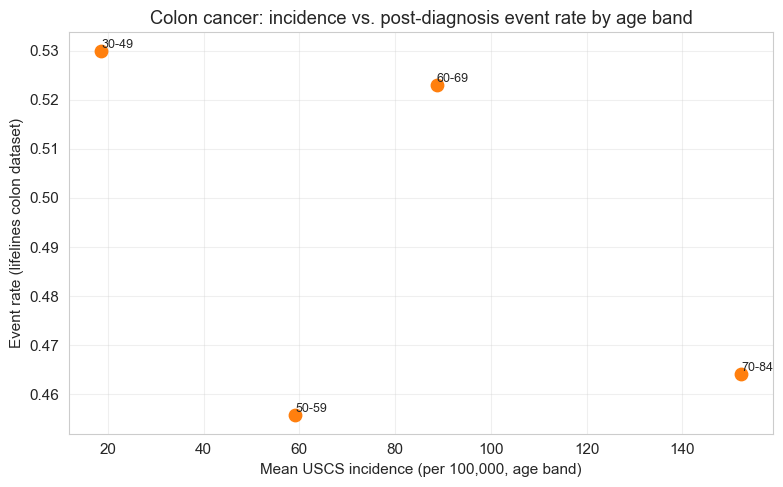

In [109]:
# Cross-table: USCS colon incidence vs lifelines colon survival, by age band

# We assume that ages_colon, rates_colon (USCS) and age_summary (lifelines
# colon survival summary) have been computed in previous cells.

if 'ages_colon' not in globals() or 'rates_colon' not in globals():
    print("Colon incidence arrays not found; run the USCS colon incidence cell above.")
elif 'age_summary' not in globals():
    print("age_summary from the lifelines colon dataset not found; run the lifelines colon summary cell above.")
else:
    colon_inc_df = pd.DataFrame({"age": ages_colon, "rate": rates_colon})

    # Use the same age bands as for the lifelines summary
    age_bins = [30, 50, 60, 70, 85]
    age_labels = ["30-49", "50-59", "60-69", "70-84"]
    colon_inc_df["age_group"] = pd.cut(colon_inc_df["age"], bins=age_bins, labels=age_labels, right=True)

    inc_summary = (
        colon_inc_df
        .groupby("age_group")
        .agg(mean_incidence=("rate", "mean"))
        .reset_index()
    )

    # Merge with lifelines age_summary on age_group
    cols_surv = ["age_group", "n", "event_rate", "median_time"]
    cross_colon = pd.merge(inc_summary, age_summary[cols_surv], on="age_group", how="inner")

    print("Combined USCS incidence and lifelines survival for colon cancer (by age group):")
    display(cross_colon)

    # Visualize mean incidence vs event rate
    plt.figure(figsize=(8, 5))
    plt.scatter(cross_colon["mean_incidence"], cross_colon["event_rate"], s=80, color="tab:orange")
    for _, row in cross_colon.iterrows():
        plt.text(row["mean_incidence"], row["event_rate"], row["age_group"], fontsize=9,
                 ha="left", va="bottom")
    plt.xlabel("Mean USCS incidence (per 100,000, age band)")
    plt.ylabel("Event rate (lifelines colon dataset)")
    plt.title("Colon cancer: incidence vs. post-diagnosis event rate by age band")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

